In [ ]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets

import numpy as np
import tqdm

import time

from torch.utils.data import DataLoader
from torch import optim

In [ ]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


In [ ]:
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

In [ ]:
batch_size = 256

train_dataset = dsets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

val_dataset = dsets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1: # When Downsampling,
            self.downsample = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels, 3, 2, 1),
                                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None
    
    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = F.relu(out)
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            x = self.downsample(x)
        out += x
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = []
        for _ in range(n):
            self.layer1.append(ResidualBlock(16, 16, 1))
        self.layer2 = [ResidualBlock(16, 32, 2)]
        for _ in range(n-1):
            self.layer2.append(ResidualBlock(32, 32, 1))
        self.layer3 = [ResidualBlock(32, 64, 2)]
        for _ in range(n-1):
            self.layer3.append(ResidualBlock(64, 64, 1))
        
        self.layer1 = nn.Sequential(*self.layer1)
        self.layer2 = nn.Sequential(*self.layer2)
        self.layer3 = nn.Sequential(*self.layer3)

        self.pool = nn.AvgPool2d(8)
        self.linear = nn.Linear(64, 10)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)

        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [ ]:
net = ResNet(3).to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=0.001, momentum=0.9)

In [ ]:
total_epoch = 60
total_batch = len(train_loader)

In [ ]:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

In [ ]:
print("Train Start")
start = time.time()
lr = 0.1

for epoch in range(total_epoch):
    avg_cost = 0.0
    train_loss = 0
    train_total = 0

    if epoch % 20 == 0:
        lr *= 0.05

    optimizer = optim.SGD(net.parameters(), lr, weight_decay=0.001, momentum=0.9)
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = net(x)
        
        cost = criterion(y_pred, y)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost

        train_loss += cost.item()
        train_total += (torch.argmax(y_pred, dim=1) == y).sum().item()

    avg_cost /= total_batch
    train_loss = train_loss / len(train_loader)
    train_acc = train_total / len(train_dataset)

    if (epoch+1) % 10 == 0:
      print("Epoch: %d/%d, Cost: %f" % (epoch+1, total_epoch, avg_cost))

      #매 epoch이 끝날 때마다 validation을 진행합니다.
    with torch.no_grad():
      val_loss = 0.0
      total = 0
      for val_step, val in enumerate(val_loader):
        val_x, val_label = val
        
        val_x = val_x.to(device)
        val_label = val_label.to(device)

        val_output = net(val_x)
        v_loss = criterion(val_output, val_label)
        val_loss += v_loss
        total += (torch.argmax(val_output, dim=1) == val_label).sum().item()

      val_loss = val_loss / len(val_loader)
      val_acc = total / len(val_dataset)

    print("epoch: {}/{} | train loss: {} | val loss: {}".format(
                  epoch+1, total_epoch, train_loss , val_loss))
    print("train acc : {}".format(train_acc))
    print("val_acc: {}".format(val_acc))

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

end = time.time()

t = int(end - start)
print("Training time: %dm %ds" %(t//60, t%60))
print("Training Finished")

Train Start
epoch: 1/60 | train loss: 0.1733194816553471 | val loss: 0.39071065187454224
train acc : 0.94032
val_acc: 0.8745
epoch: 2/60 | train loss: 0.17957217014413707 | val loss: 0.3981877863407135
train acc : 0.93706
val_acc: 0.8748
epoch: 3/60 | train loss: 0.17844558697269888 | val loss: 0.39400336146354675
train acc : 0.93874
val_acc: 0.8739
epoch: 4/60 | train loss: 0.17997512422806147 | val loss: 0.38778984546661377
train acc : 0.93682
val_acc: 0.8765
epoch: 5/60 | train loss: 0.17789042790477372 | val loss: 0.386470764875412
train acc : 0.93846
val_acc: 0.8779
epoch: 6/60 | train loss: 0.1744462442489303 | val loss: 0.37844035029411316
train acc : 0.9401
val_acc: 0.8787
epoch: 7/60 | train loss: 0.17138195448383994 | val loss: 0.39378076791763306
train acc : 0.94096
val_acc: 0.8762
epoch: 8/60 | train loss: 0.1781508602506044 | val loss: 0.39079439640045166
train acc : 0.93784
val_acc: 0.8748
epoch: 9/60 | train loss: 0.17298448469717892 | val loss: 0.3974548280239105
train 

In [ ]:
print("Test Start")

correct = 0.0
total = 0.0

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += ((predicted == labels).sum().item())

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Test Start
Accuracy of the network on the 10000 test images: 89.0 %


Show Loss plot


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


TypeError: ignored

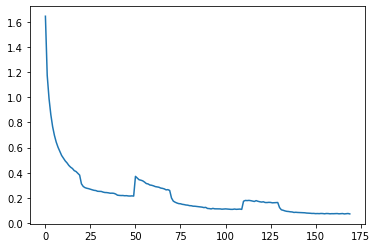

In [ ]:
print("Show Loss plot")

plt.plot(train_loss_history, label = ' train_loss')
val_loss = torch.stack(val_loss)
plt.plot(val_loss_history, label = 'val_loss')
plt.legend()
plt.show()

Show Acc plot


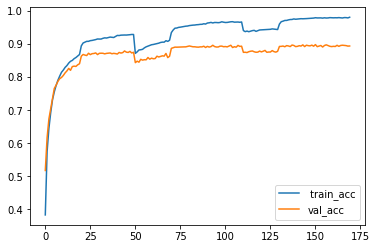

In [ ]:
print("Show Acc plot")

plt.plot(train_acc_history, label = ' train_acc')
plt.plot(val_acc_history, label = 'val_acc')
plt.legend()
plt.show()